<a href="https://colab.research.google.com/github/FarhanAgil/PCVK_Genap2022/blob/main/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Memasukkan Library Yang Dibutuhkan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

Mengakses ke Google Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
arr_name_file = []
# folder path
dir_path = r'/content/drive/MyDrive/PCVK/Brain Tumor/'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    arr_name_file.append(path)
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1

print('File count:', count)

File count: 30


In [4]:
brain_tumor_image_merged = []
for image in arr_name_file:
    fix_path ='/content/drive/MyDrive/PCVK/Brain Tumor/' + image
    result_image = cv.imread(fix_path)
    result_image = cv.cvtColor(result_image , cv.COLOR_BGR2GRAY)  # Ubah Gambar ke dalam grayscale 
    dim = (180 , 218)
    result_image = cv.resize(result_image, dim , interpolation=cv.INTER_AREA) # Mengecilkan bentuk gambar
    result_image = cv.medianBlur(result_image , 5) # Menghilangkan Noise
    result_image = cv.equalizeHist(result_image) # 
    brain_tumor_image_merged.append(result_image)


Alasan Mengapa diubah ke Grayscale karena agar mengurangi komputasi

In [5]:
print(brain_tumor_image_merged[0].shape)

(218, 180)


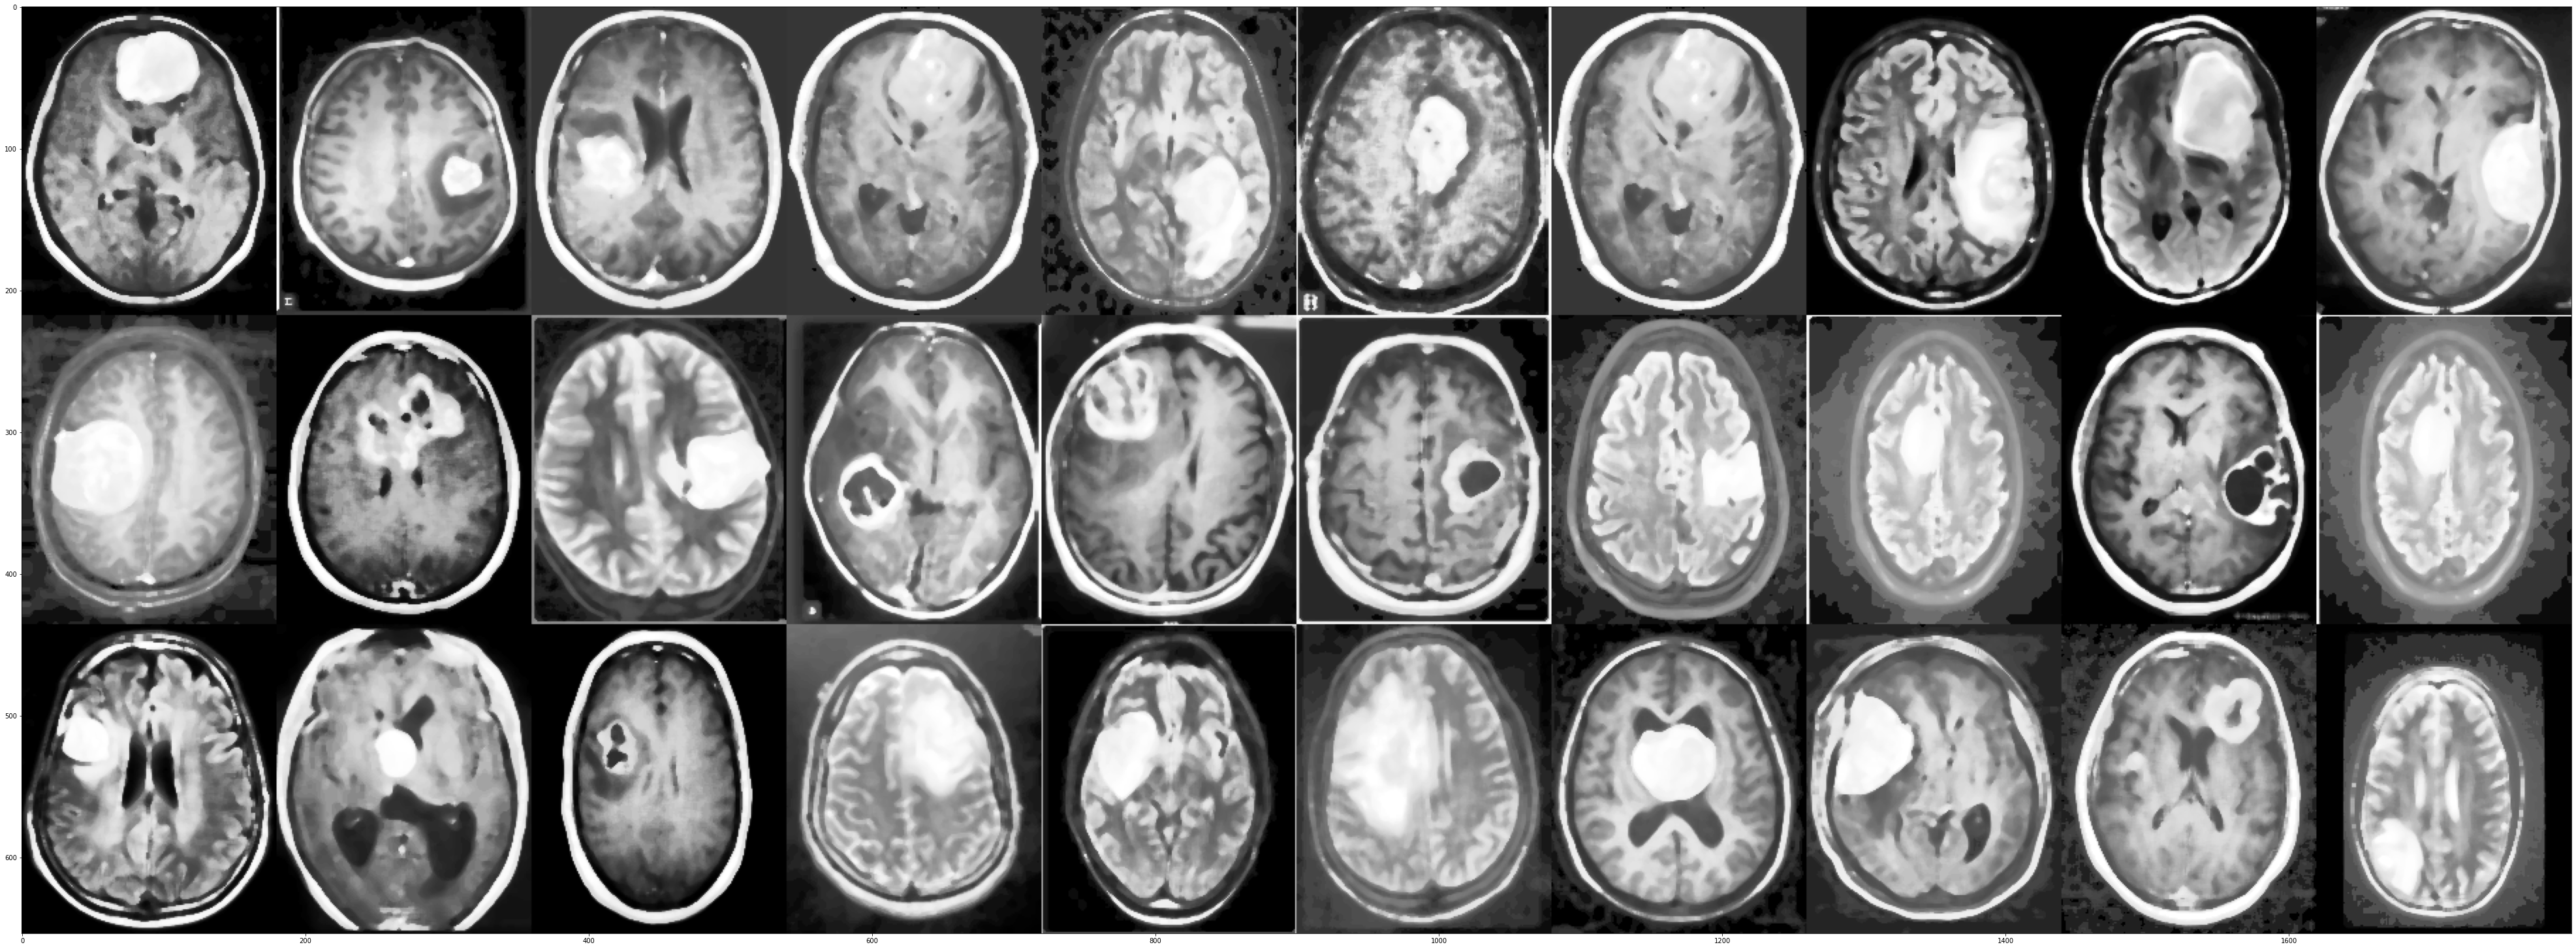

In [6]:
im_h = cv.hconcat(brain_tumor_image_merged[0:10]) # Bentuk Horizontal
im_h_second = cv.hconcat(brain_tumor_image_merged[10:20])
im_h_third = cv.hconcat(brain_tumor_image_merged[20:31])

im_total = cv.vconcat([im_h , im_h_second , im_h_third])
plt.figure(figsize=(70 , 100))
plt.imshow(im_total , cmap='gray')

**Membuat Fungsi Binary Threshold**

Binary Threshold adalah Mengubah warna menjadi nilai 0 dan 255. Binary Threshold seperti yang dijelaskan sebelumnya, merupakan threshold yang akan
memisahkan dua grup warna. Untuk threshold ini, masing-masing kelompok warna akan diubah ke nilai gelap (hitam) untuk object yang dianggap background, dan diubah ke nilai terang (putih) untuk object yang dianggap foreground.

In [7]:
def do_binary_threshold(image):
    #ret2,th2 = cv.threshold(image,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    (T, thresh) = cv.threshold(image, 200, 255, cv.THRESH_BINARY)
    #th2 = cv.adaptiveThreshold(image , 255,  cv.ADAPTIVE_THRESH_GAUSSIAN_C , cv.THRESH_BINARY, 11 , 2)
    return thresh

**Membuat Fungsi Inverse Binary Threshold**

Threshold ini merupakan kebalikan dari Binary Threshold. Jika intensitas warna diatas Threshold, maka nilai akan diubah menjadi 0 dan sebaliknya.

In [8]:
def do_inverse_binary_threshold(image):
    (T, threshInv) = cv.threshold(image, 155, 255,cv.THRESH_BINARY_INV)
    return threshInv

**Membuat Fungsi Morfologi (Closing)**

Tujuan: menutup atau menghilangkan lubang-lubang kecil yang ada dalam segmen
objek, serta menggabungkan objek yang berdekatan tanpa mengubah objek secara
signifikan.


In [9]:
def do_morphology(image):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
    # kernel = cv.getStructuringElement(cv.MORPH_RECT, (10, 5))
    opening = cv.morphologyEx(image, cv.MORPH_OPEN, kernel , iterations=2)
    closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel , iterations=2)
    return closing

**Membuat Batas Tepi Auto Canny**

Tujuan : menghaluskan gambar dengan filter Gaussian untuk mengurangi noise, menghitung gradien menggunakan salah satu operator gradien Sobel, mengekstraksi titip tepi: Non-maximum suppression, menghubungkan dan thresholding: Hysteresis

In [10]:
def auto_canny(image, sigma=0.33):
     # compute the median of the single channel pixel intensities
     v = np.median(image)

    # apply automatic Canny edge detection using the computed median
     lower = int(max(0, (1.0 - sigma) * v))
     upper = int(min(255, (1.0 + sigma) * v))
     edged = cv.Canny(image, lower, upper)

    # return the edged image
     return edged

Membuat Fungsi Counter

In [11]:
def do_findCounter(image , original_image):
    (cnts, _) = cv.findContours(image ,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    original_image = cv.cvtColor(original_image , cv.COLOR_GRAY2RGB)
    original_image  = cv.drawContours(original_image, cnts, -1, (255, 0, 0), 2)
    return original_image

Membuat variabel hasil dari membuat fungsi-fungsi sebelumnya agar lebih mudah memanggil. Dan juga variabel hasil ini juga telah ditambahkan gambar dataset.

In [12]:
image_result_binary = []
image_result_canny = []
image_result_morpho = []
alpha = 1
beta = 20
for list in range(0 , 30):

    image_copy = do_binary_threshold(brain_tumor_image_merged[list])
    image_result_binary.append(image_copy)
    image_copy = do_morphology(image_copy)
    image_result_morpho.append(image_copy)
    image_copy =  auto_canny(image_copy)
    image_result_canny.append(image_copy)
    brain_tumor_image_merged[list]= do_findCounter(image_copy , brain_tumor_image_merged[list])

Menampilkan gambar yang sudah di binary threshold dan ditampilkan dalam bentuk horizontal. Disini dibuat 3 variabel untuk masing masing variabel terdiri dari 10 gambar, karena isi datasetnya totalnya 30 gambar.

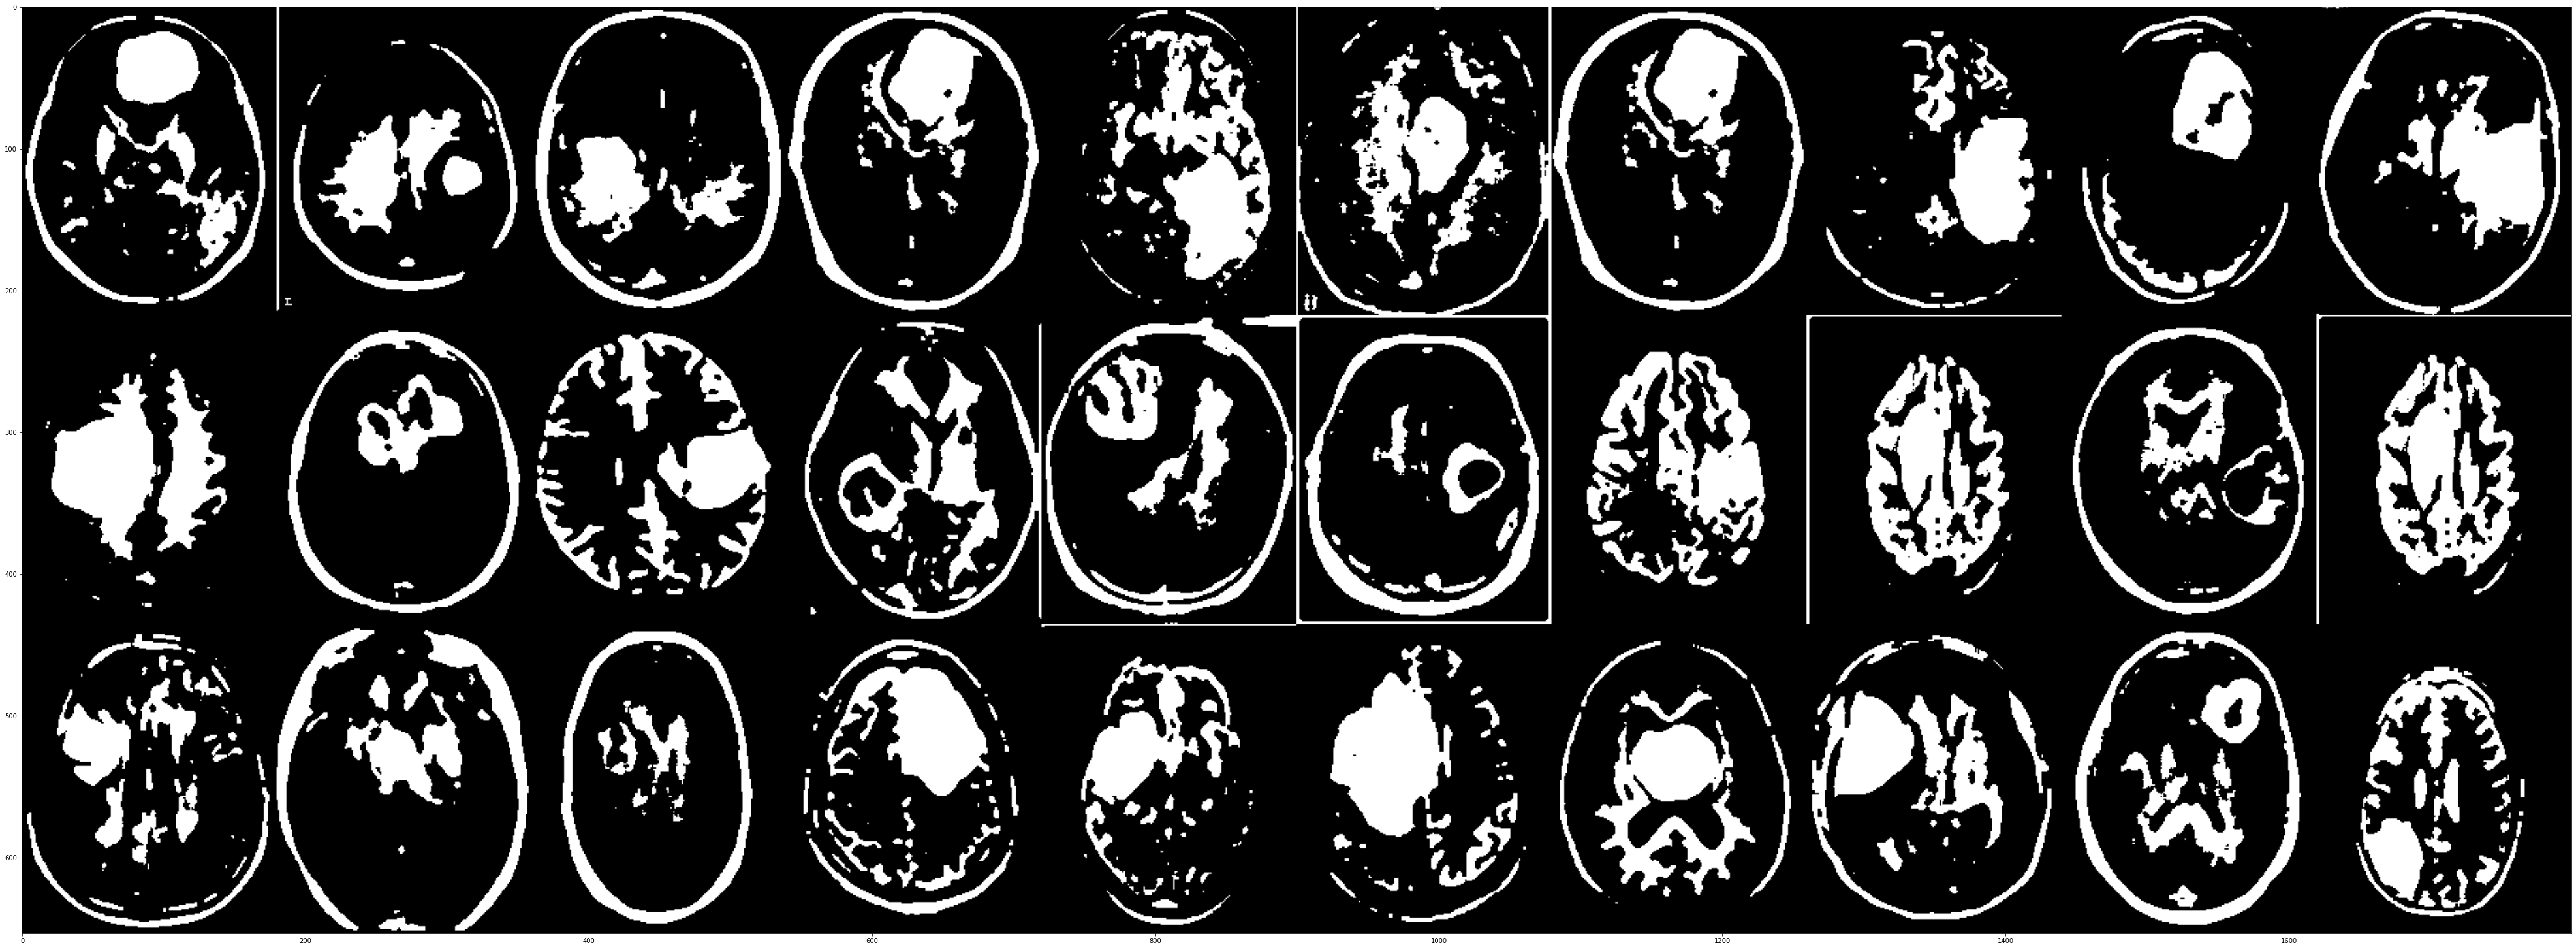

In [13]:
im_h = cv.hconcat(image_result_binary[0:10])
im_h_second = cv.hconcat(image_result_binary[10:20])
im_h_third = cv.hconcat(image_result_binary[20:31])

im_total = cv.vconcat([im_h , im_h_second , im_h_third])
plt.figure(figsize=(70 , 100))
plt.imshow(im_total , cmap='gray')

Menampilkan gambar yang sudah di pre-processing dengan morfologi (closing).

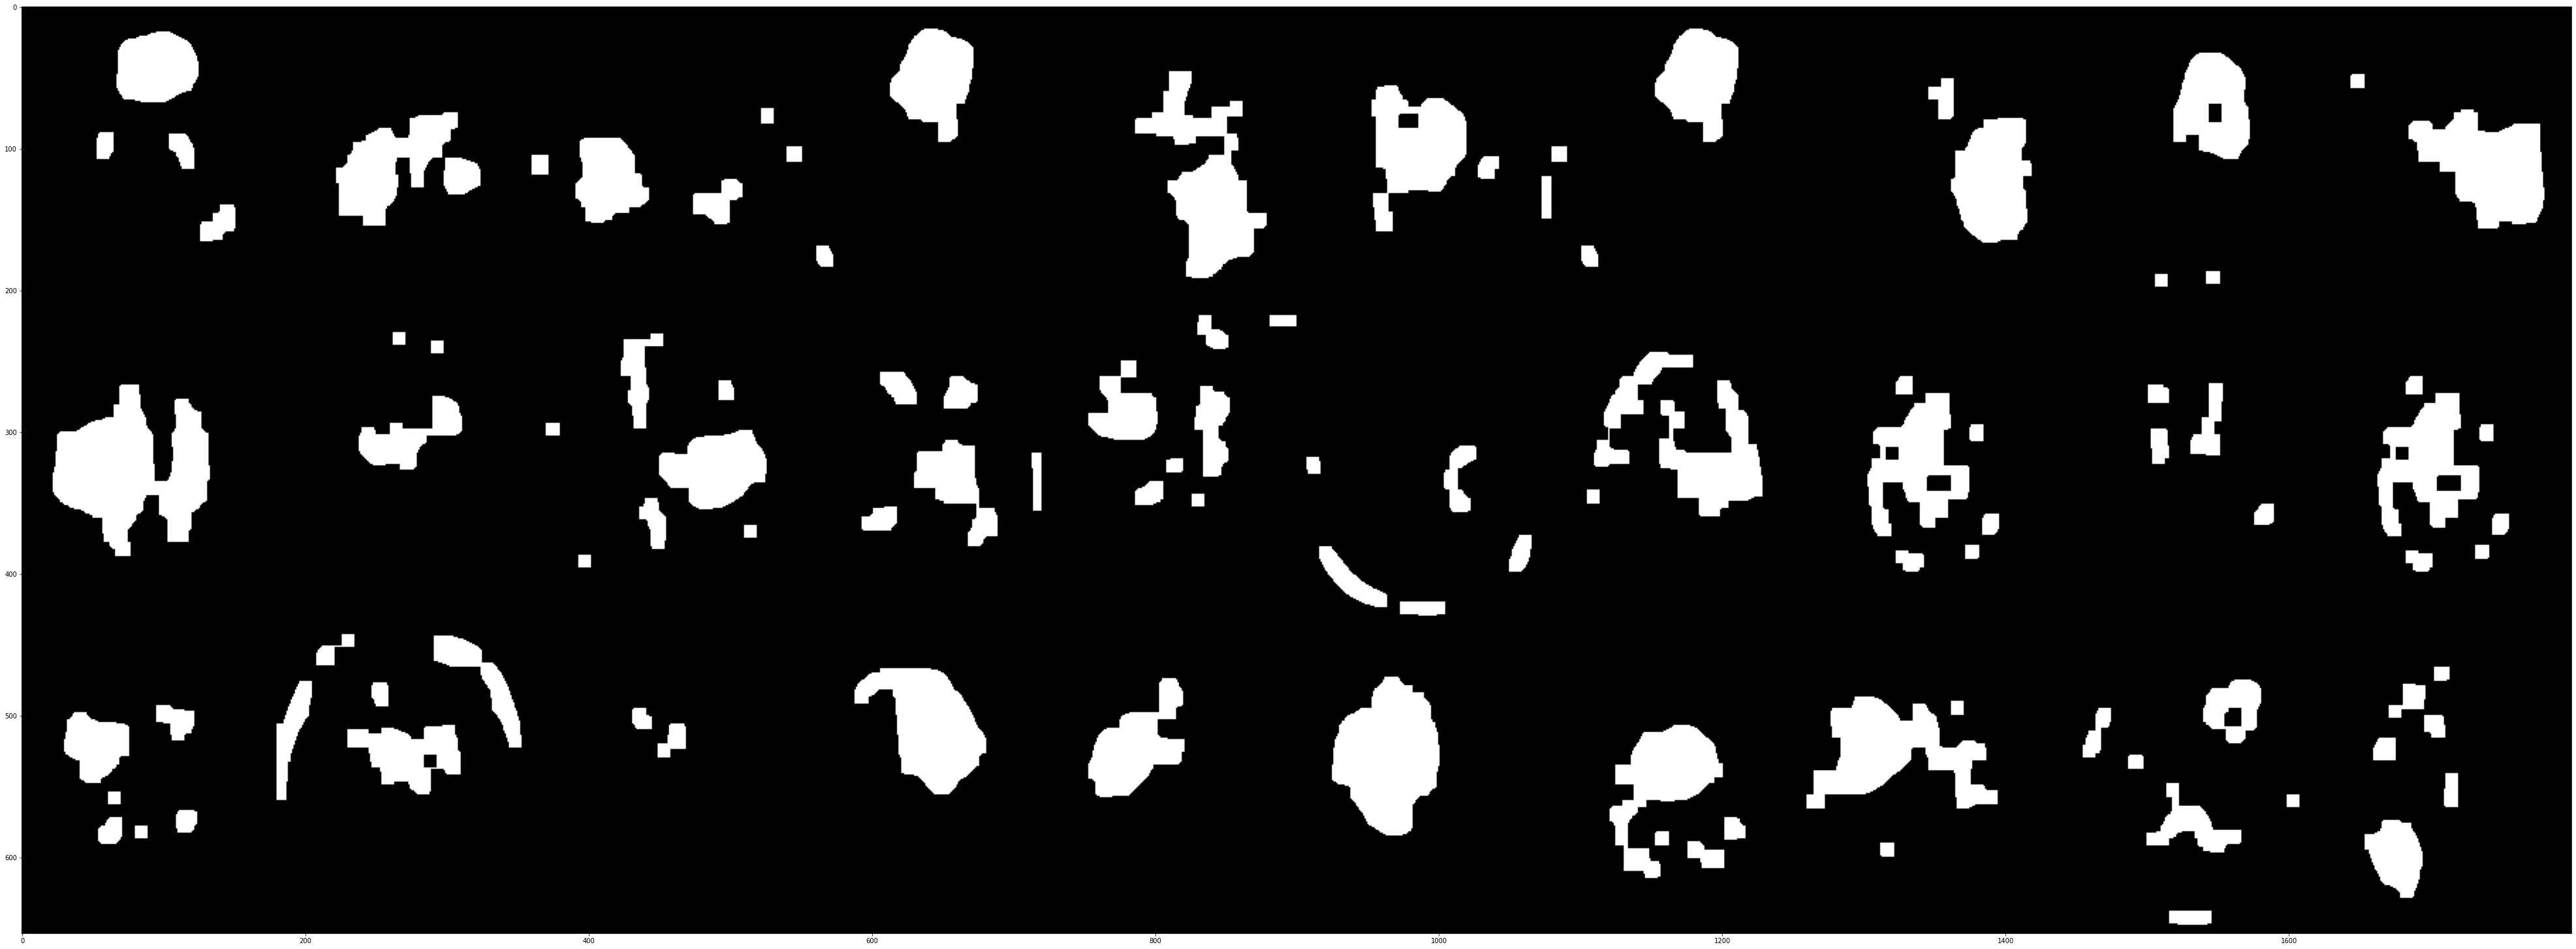

In [14]:
im_h = cv.hconcat(image_result_morpho[0:10])
im_h_second = cv.hconcat(image_result_morpho[10:20])
im_h_third = cv.hconcat(image_result_morpho[20:31])

im_total = cv.vconcat([im_h , im_h_second , im_h_third])
plt.figure(figsize=(70 , 100))
plt.imshow(im_total , cmap='gray')

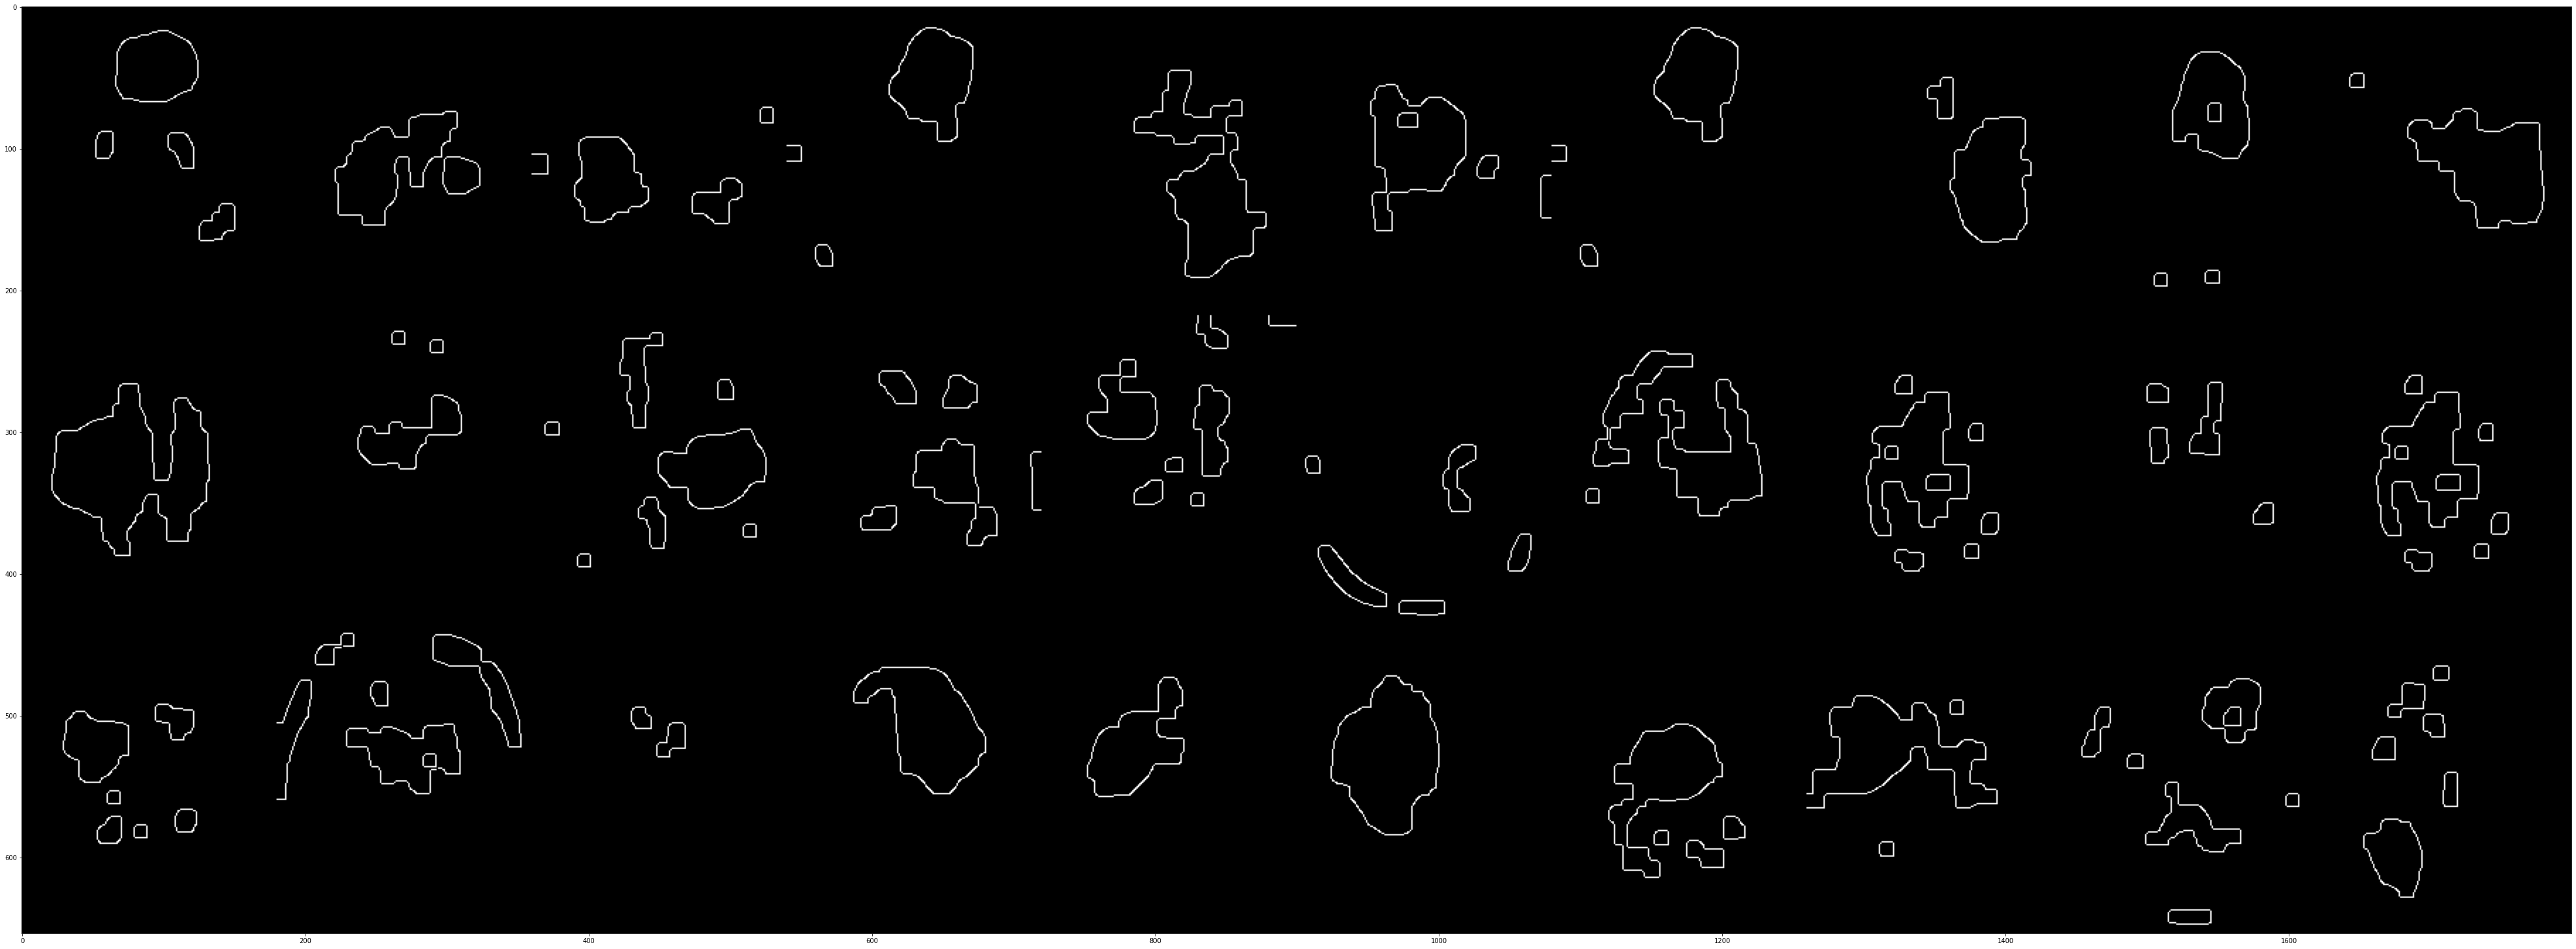

In [15]:
im_h = cv.hconcat(image_result_canny[0:10])
im_h_second = cv.hconcat(image_result_canny[10:20])
im_h_third = cv.hconcat(image_result_canny[20:31])

im_total = cv.vconcat([im_h , im_h_second , im_h_third])
plt.figure(figsize=(70 , 100))
plt.imshow(im_total , cmap='gray')

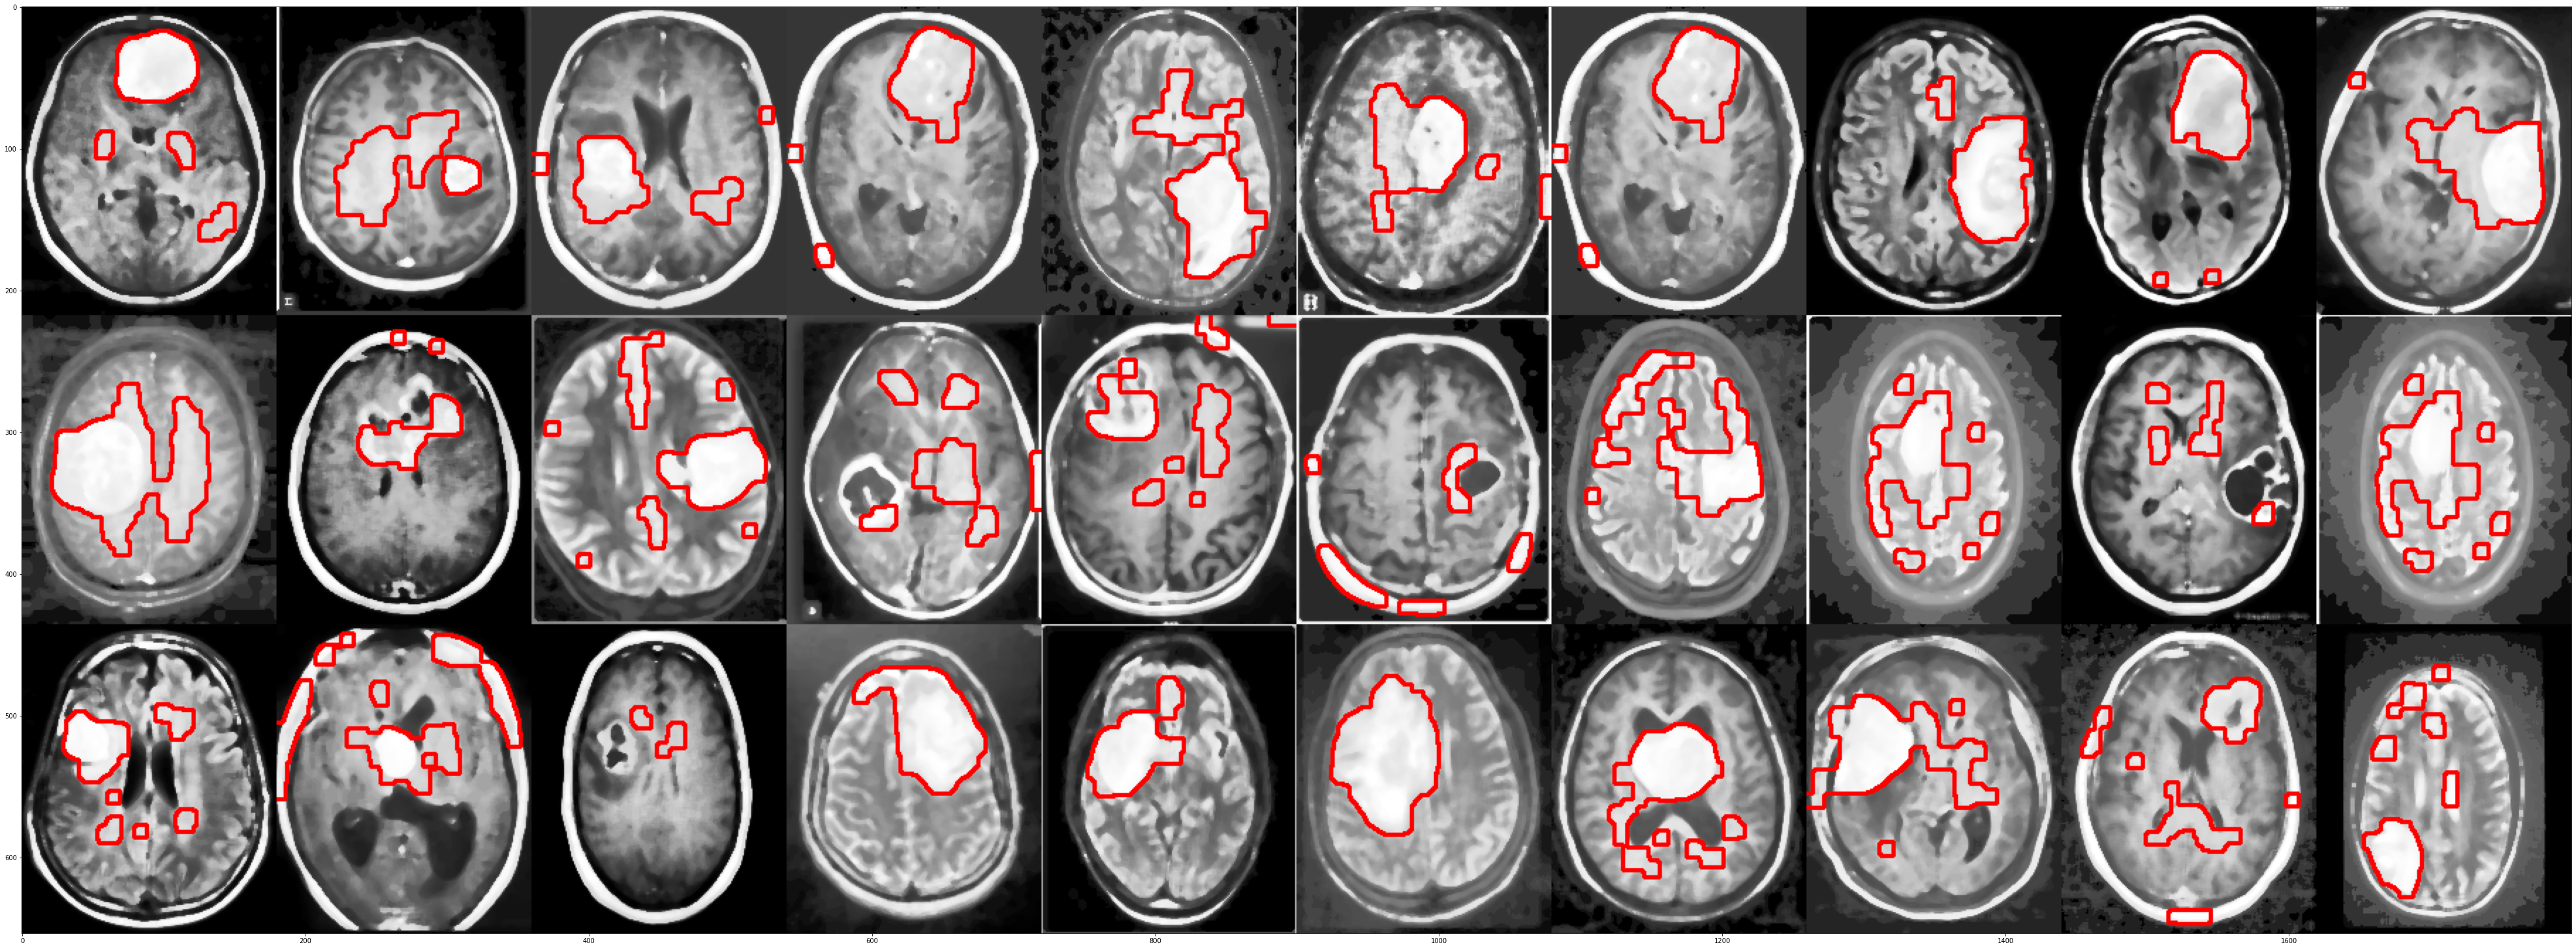

In [16]:
im_h = cv.hconcat(brain_tumor_image_merged[0:10])
im_h_second = cv.hconcat(brain_tumor_image_merged[10:20])
im_h_third = cv.hconcat(brain_tumor_image_merged[20:31])

im_total = cv.vconcat([im_h , im_h_second , im_h_third])
plt.figure(figsize=(70 , 100))
plt.imshow(im_total , cmap='gray')